The CIFAR-10 dataset (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research. The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class.

## Import packages needed 

In [1]:
import datetime
import time
import numpy as np
import pandas as pd
from packaging import version
from collections import Counter

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

In [2]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

## Verify TF Version and Keras Version

In [3]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.8.0


In [4]:
print("Keras version: ", keras.__version__)

Keras version:  2.8.0


In [6]:
def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions)))) 

In [7]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.<br>

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.


* Tuple of Numpy arrays: (x_train, y_train), (x_test, y_test).
* x_train, x_test: uint8 arrays of color image data with shapes (num_samples, 32, 32).
* y_train, y_test: uint8 arrays of digit labels (integers in range 0-9)



* Imported 50000 examples for training and 10000 examples for test 
* Imported 50000 labels for training and 10000 labels for test 

## Review labels

In [10]:
print("First ten labels training dataset:\n {}\n".format(y_train[0:10]))
print("This output the numeric label, need to convert to item description")

First ten labels training dataset:
 [[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]

This output the numeric label, need to convert to item description


## Plot Examples

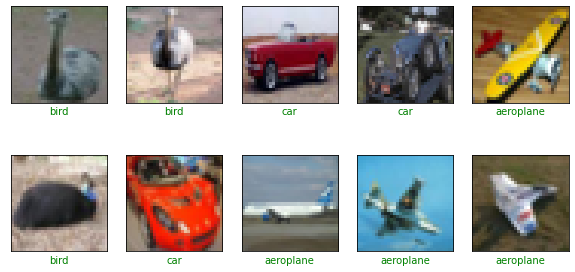

In [14]:
class_names_preview = ['aeroplane', 'car', 'bird']

def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names_preview[np.argmax(p[i])], color=col)
    plt.show()

show_random_examples(x_preview, y_preview, y_preview)

## Data for Model Development

The labels are an array of integers, ranging from 0 to 9. These correspond to the class of clothing the image represents:

|Label  |Class_  |
|-------|--------|
|0|	airplane     |
|1|	automobile   |
|2|	bird         |
|3|	cat          |
|4|	deer         |
|5|	dog          |
|6|	frog         |
|7|	horse        |
|8|	ship         |
|9|	truck        |

In [15]:
class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

In [16]:
x_train_split, x_valid_split, y_train_split, y_valid_split = train_test_split(x_train
                                                                              ,y_train
                                                                              ,test_size=.1
                                                                              ,random_state=42
                                                                              ,shuffle=True)

In [17]:
print(x_train_split.shape, x_valid_split.shape, x_test.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3) (10000, 32, 32, 3)



The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255
 

1. Each element in each example is a pixel value
2. Pixel values range from 0 to 255
3. 0 = black
4. 255 = white

In [20]:
y_train_encoded = to_categorical(y_train_split)
y_valid_encoded = to_categorical(y_valid_split)

print('y_train_encoded shape: ', y_train_encoded.shape)
print('y_valid_encoded shape: ', y_valid_encoded.shape)

## Create the Model

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/CNN_architecture_v4.png?raw=1">


We use a Sequential class defined in Keras to create our model. The first 9 layers Conv2D MaxPooling, Dropout handle feature learning.  The last 3 layers, handle classification

In [41]:
model = models.Sequential()
model.add(layers.Flatten(input_shape = (32,32,3)))
model.add(layers.Dense(64, activation = 'relu', kernel_regularizer = tf.keras.regularizers.L2(0.001)))
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(10, activation = 'softmax'))

In [42]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 3072)              0         
                                                                 
 dense_11 (Dense)            (None, 64)                196672    
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dense_13 (Dense)            (None, 10)                650       
                                                                 
Total params: 201,482
Trainable params: 201,482
Non-trainable params: 0
_________________________________________________________________


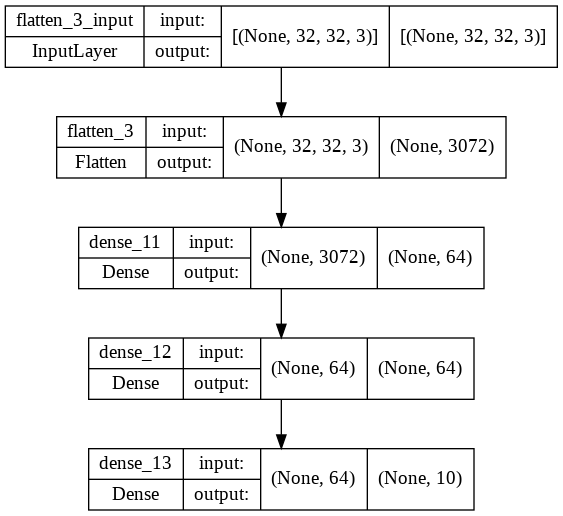

In [43]:
keras.utils.plot_model(model, "CIFAR10.png", show_shapes=True) 

In [44]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [45]:
history = model.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=512
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    tf.keras.callbacks.ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/models/model_{val_accuracy:.4f}.h5', save_best_only=True,
                                        save_weights_only=False, monitor='val_accuracy')]                                                                                                           
                   )

Epoch 1/200
88/88 [==============================] - 1s 8ms/step - loss: 2.1684 - accuracy: 0.2526 - val_loss: 1.9928 - val_accuracy: 0.3200
Epoch 2/200
88/88 [==============================] - 1s 6ms/step - loss: 1.9401 - accuracy: 0.3418 - val_loss: 1.9085 - val_accuracy: 0.3418
Epoch 3/200
88/88 [==============================] - 0s 6ms/step - loss: 1.8644 - accuracy: 0.3620 - val_loss: 1.8583 - val_accuracy: 0.3576
Epoch 4/200
88/88 [==============================] - 1s 6ms/step - loss: 1.8001 - accuracy: 0.3850 - val_loss: 1.7941 - val_accuracy: 0.3850
Epoch 5/200
88/88 [==============================] - 1s 6ms/step - loss: 1.7598 - accuracy: 0.3982 - val_loss: 1.7472 - val_accuracy: 0.3968
Epoch 6/200
88/88 [==============================] - 1s 10ms/step - loss: 1.7180 - accuracy: 0.4102 - val_loss: 1.7181 - val_accuracy: 0.4058
Epoch 7/200
88/88 [==============================] - 0s 5ms/step - loss: 1.6865 - accuracy: 0.4208 - val_loss: 1.7106 - val_accuracy: 0.4110
Epoch 8/200


In [49]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
11,1.603,0.450,1.628,0.434
12,1.592,0.454,1.628,0.434
13,1.578,0.457,1.631,0.433
14,1.567,0.460,1.635,0.429
15,1.560,0.464,1.631,0.426


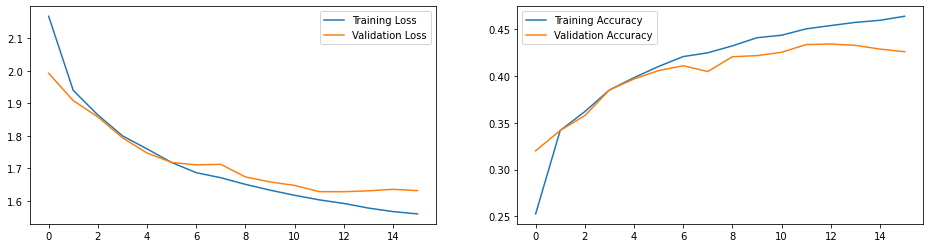

In [51]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [52]:
pred1= model.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)

In [53]:
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.53      0.45      0.49      1000
           1       0.59      0.54      0.56      1000
           2       0.32      0.32      0.32      1000
           3       0.31      0.27      0.29      1000
           4       0.45      0.31      0.37      1000
           5       0.42      0.28      0.34      1000
           6       0.35      0.71      0.47      1000
           7       0.61      0.40      0.48      1000
           8       0.48      0.70      0.57      1000
           9       0.53      0.49      0.51      1000

    accuracy                           0.45     10000
   macro avg       0.46      0.45      0.44     10000
weighted avg       0.46      0.45      0.44     10000

Accuracy Score: 0.4466
Root Mean Square Error: 3.200124997558689


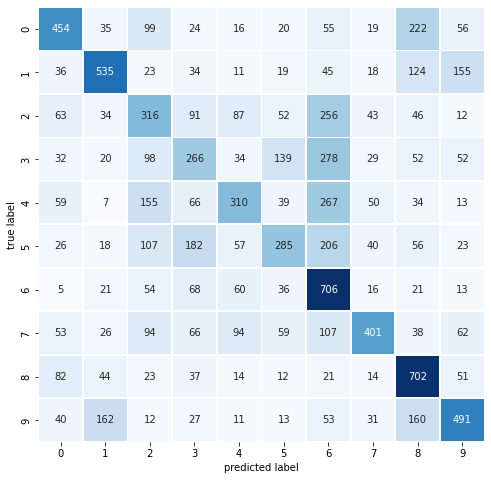

In [54]:
plot_confusion_matrix(y_test,pred1)

In [55]:
model = models.Sequential()
model.add(layers.Flatten(input_shape = (32,32,3)))
model.add(layers.Dense(64, activation = 'relu', kernel_regularizer = tf.keras.regularizers.L2(0.001)))
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(64,activation = 'relu'))
model.add(layers.Dense(10, activation = 'softmax'))

In [56]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 3072)              0         
                                                                 
 dense_14 (Dense)            (None, 64)                196672    
                                                                 
 dense_15 (Dense)            (None, 64)                4160      
                                                                 
 dense_16 (Dense)            (None, 64)                4160      
                                                                 
 dense_17 (Dense)            (None, 10)                650       
                                                                 
Total params: 205,642
Trainable params: 205,642
Non-trainable params: 0
_________________________________________________________________


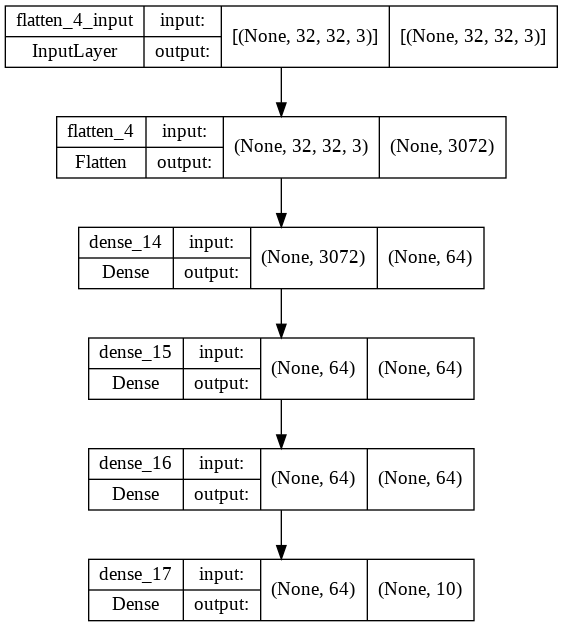

In [57]:
keras.utils.plot_model(model, "CIFAR10.png", show_shapes=True) 

In [58]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [59]:
history = model.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=512
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    tf.keras.callbacks.ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/models/model_{val_accuracy:.4f}.h5', save_best_only=True,
                                        save_weights_only=False, monitor='val_accuracy')]                                                                                                           
                   )

Epoch 1/200
88/88 [==============================] - 1s 8ms/step - loss: 2.0976 - accuracy: 0.2658 - val_loss: 1.9237 - val_accuracy: 0.3294
Epoch 2/200
88/88 [==============================] - 1s 6ms/step - loss: 1.8688 - accuracy: 0.3515 - val_loss: 1.8214 - val_accuracy: 0.3600
Epoch 3/200
88/88 [==============================] - 1s 10ms/step - loss: 1.7857 - accuracy: 0.3788 - val_loss: 1.7672 - val_accuracy: 0.3814
Epoch 4/200
88/88 [==============================] - 1s 6ms/step - loss: 1.7275 - accuracy: 0.4005 - val_loss: 1.7397 - val_accuracy: 0.3900
Epoch 5/200
88/88 [==============================] - 1s 6ms/step - loss: 1.6936 - accuracy: 0.4112 - val_loss: 1.6979 - val_accuracy: 0.4016
Epoch 6/200
88/88 [==============================] - 1s 6ms/step - loss: 1.6669 - accuracy: 0.4201 - val_loss: 1.6824 - val_accuracy: 0.4096
Epoch 7/200
88/88 [==============================] - 0s 6ms/step - loss: 1.6413 - accuracy: 0.4310 - val_loss: 1.6590 - val_accuracy: 0.4156
Epoch 8/200


In [60]:
loss, accuracy = model.evaluate(x_test_norm, y_test)
print('test set accuracy: ', accuracy * 100)

313/313 [==============================] - 1s 2ms/step - loss: 1.5180 - accuracy: 0.4788
test set accuracy:  47.87999987602234


In [61]:
preds = model.predict(x_test_norm)
print('shape of preds: ', preds.shape)

shape of preds:  (10000, 10)


In [62]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [63]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
18,1.497,0.483,1.566,0.449
19,1.483,0.488,1.560,0.453
20,1.477,0.491,1.564,0.450
21,1.470,0.493,1.566,0.447
22,1.467,0.497,1.558,0.451


In [64]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

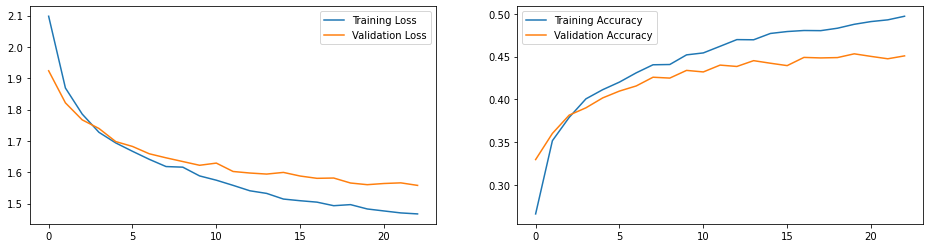

In [65]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [67]:
print_validation_report(y_test, x_test,pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.53      0.57      0.55      1000
           1       0.53      0.65      0.58      1000
           2       0.41      0.28      0.33      1000
           3       0.33      0.30      0.32      1000
           4       0.49      0.26      0.34      1000
           5       0.38      0.37      0.38      1000
           6       0.45      0.63      0.53      1000
           7       0.47      0.58      0.52      1000
           8       0.65      0.57      0.61      1000
           9       0.53      0.57      0.55      1000

    accuracy                           0.48     10000
   macro avg       0.48      0.48      0.47     10000
weighted avg       0.48      0.48      0.47     10000

Accuracy Score: 0.4788
Root Mean Square Error: 3.1730269459933678


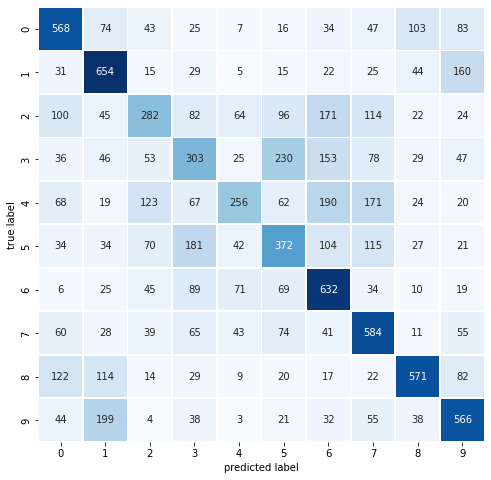

In [68]:
plot_confusion_matrix(y_test,,y_test,pred1)

In [ ]:
model = models.Sequential()
model.add(layers.Conv3D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=(32, 32, 3)))
model.add(layers.MaxPool3D((2, 2),strides=2))
model.add(layers.Dropout(0.3))
model.add(layers.Conv3D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, \
                        kernel_regularizer = tf.keras.regularizers.L2(0.001)))
model.add(layers.MaxPool3D(pool_size=(2, 2),strides=2))
model.add(layers.Dropout(0.3))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 512)       14336     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 512)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 512)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 256)       1179904   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 256)        

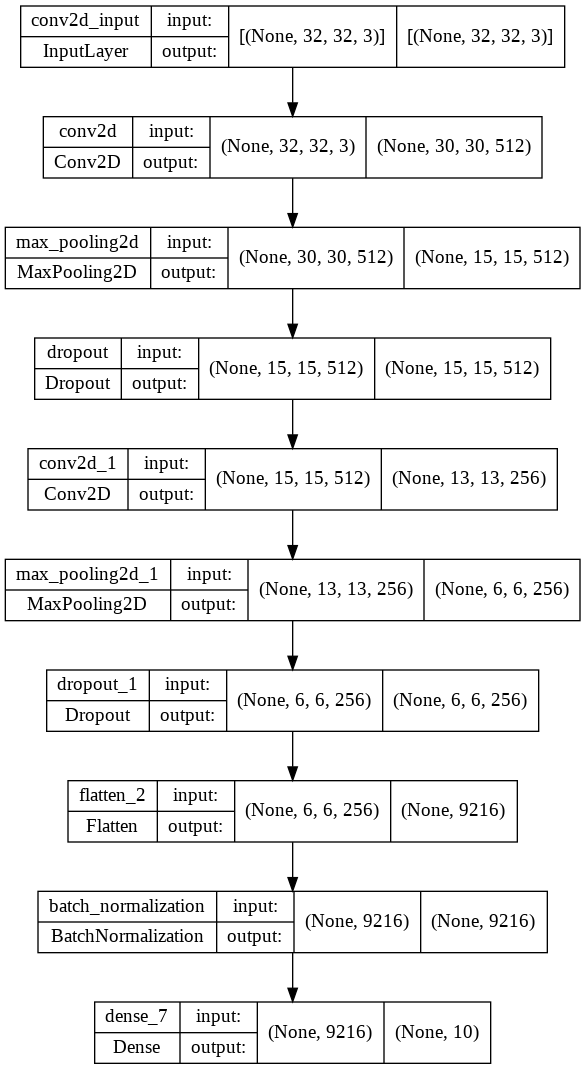

In [ ]:
keras.utils.plot_model(model, "CIFAR10.png", show_shapes=True) 

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
history = model.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=512
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    tf.keras.callbacks.ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/models/model_{val_accuracy:.4f}.h5', save_best_only=True,
                                        save_weights_only=False, monitor='val_accuracy')]                                                                                                           
                   )

Epoch 1/200
88/88 [==============================] - 29s 203ms/step - loss: 1.5537 - accuracy: 0.4492 - val_loss: 2.1788 - val_accuracy: 0.1104
Epoch 2/200
88/88 [==============================] - 15s 170ms/step - loss: 1.1499 - accuracy: 0.5967 - val_loss: 2.0124 - val_accuracy: 0.2558
Epoch 3/200
88/88 [==============================] - 15s 172ms/step - loss: 1.0074 - accuracy: 0.6503 - val_loss: 1.8565 - val_accuracy: 0.3562
Epoch 4/200
88/88 [==============================] - 15s 173ms/step - loss: 0.9238 - accuracy: 0.6791 - val_loss: 1.5454 - val_accuracy: 0.5204
Epoch 5/200
88/88 [==============================] - 15s 174ms/step - loss: 0.8669 - accuracy: 0.6988 - val_loss: 1.2227 - val_accuracy: 0.6390
Epoch 6/200
88/88 [==============================] - 15s 176ms/step - loss: 0.8205 - accuracy: 0.7154 - val_loss: 0.9938 - val_accuracy: 0.6870
Epoch 7/200
88/88 [==============================] - 15s 176ms/step - loss: 0.7822 - accuracy: 0.7280 - val_loss: 0.9105 - val_accuracy:

In [ ]:
loss, accuracy = model.evaluate(x_test_norm, y_test)
print('test set accuracy: ', accuracy * 100)

313/313 [==============================] - 2s 6ms/step - loss: 0.8908 - accuracy: 0.6992
test set accuracy:  69.91999745368958


In [ ]:
preds = model.predict(x_test_norm)
print('shape of preds: ', preds.shape)

shape of preds:  (10000, 10)


In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
10,0.682,0.762,0.798,0.726
11,0.658,0.771,0.785,0.729
12,0.651,0.774,0.895,0.701
13,0.623,0.783,0.838,0.713
14,0.611,0.787,0.875,0.704


In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

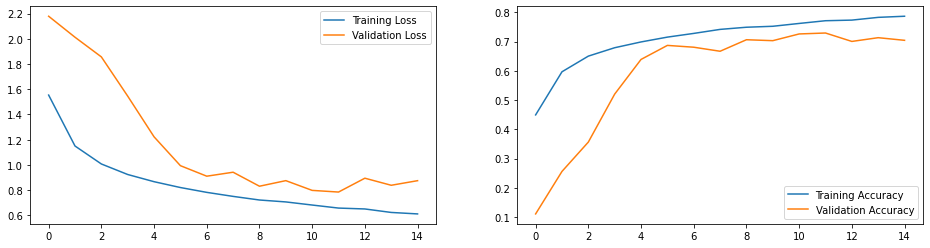

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [ ]:
pred1= model.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)

In [ ]:
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.85      0.59      0.69      1000
           1       0.95      0.69      0.80      1000
           2       0.71      0.47      0.56      1000
           3       0.54      0.58      0.56      1000
           4       0.52      0.82      0.63      1000
           5       0.72      0.54      0.62      1000
           6       0.64      0.89      0.75      1000
           7       0.82      0.70      0.76      1000
           8       0.76      0.87      0.81      1000
           9       0.74      0.84      0.79      1000

    accuracy                           0.70     10000
   macro avg       0.73      0.70      0.70     10000
weighted avg       0.73      0.70      0.70     10000

Accuracy Score: 0.6992
Root Mean Square Error: 2.2911350898626646


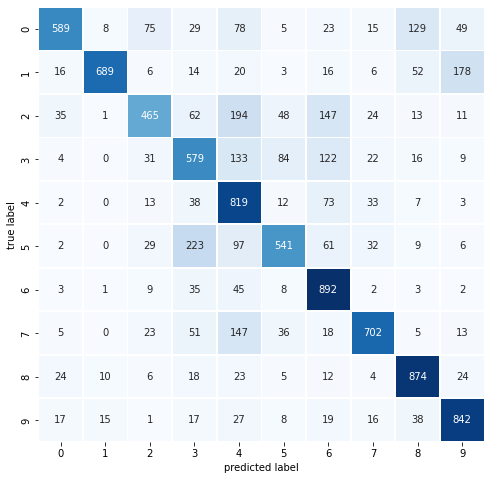

In [ ]:
plot_confusion_matrix(y_test,pred1)

In [69]:
model = models.Sequential()
model.add(layers.Conv3D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=(32, 32, 3)))
model.add(layers.MaxPool3D((2, 2),strides=2))
model.add(layers.Dropout(0.3))
model.add(layers.Conv3D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model.add(layers.MaxPool3D(pool_size=(2, 2),strides=2))
model.add(layers.Dropout(0.3))
model.add(layers.Conv3D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model.add(layers.MaxPool3D(pool_size=(2, 2),strides=2))
model.add(layers.Dropout(0.3))
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(units=384, activation = tf.nn.relu, kernel_regularizer = tf.keras.regularizers.L2(0.001)))
model.add(layers.Dense(units=512, activation=tf.nn.softmax))

In [70]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 512)       14336     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 512)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 512)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 256)       1179904   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 256)        

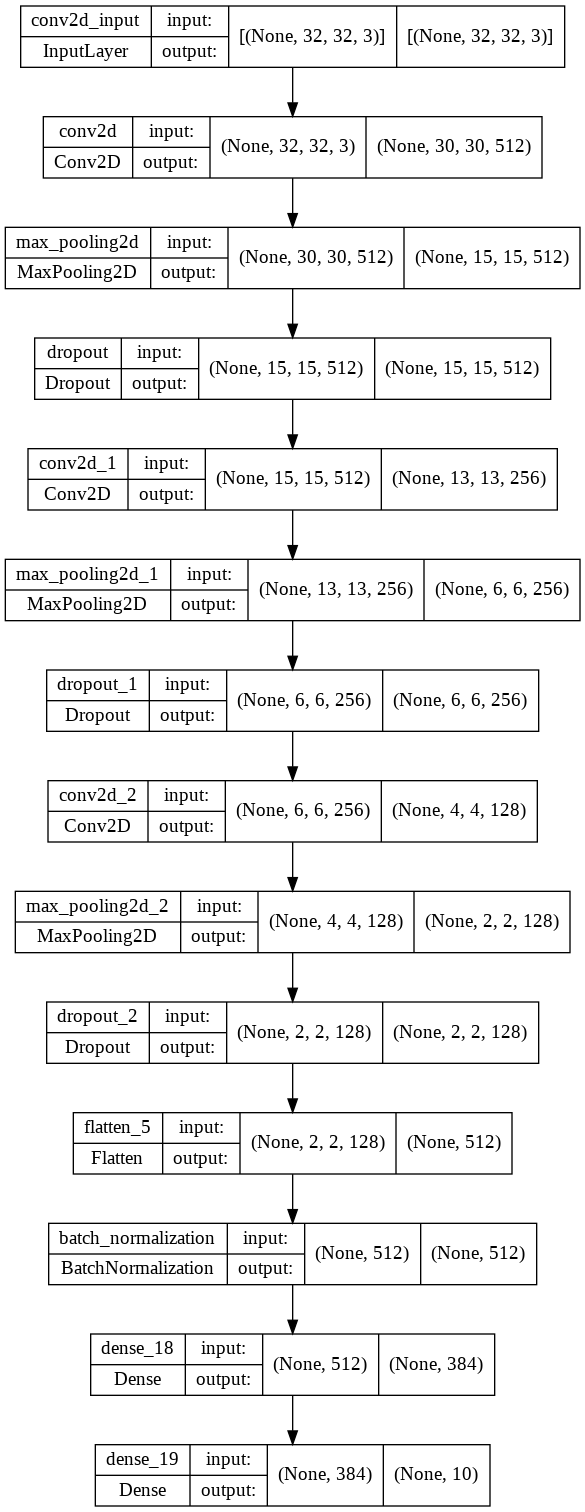

In [71]:
keras.utils.plot_model(model, "CIFAR10.png", show_shapes=True) 

In [72]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [73]:
history = model.fit(x_train_norm
                    ,y_train_split
                    ,epochs=2000
                    ,batch_size=512
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    tf.keras.callbacks.ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/models/model_{val_accuracy:.4f}.h5', save_best_only=True,
                                        save_weights_only=False, monitor='val_accuracy')]                                                                                                           
                   )

Epoch 1/200
88/88 [==============================] - 31s 215ms/step - loss: 2.1323 - accuracy: 0.3446 - val_loss: 2.2980 - val_accuracy: 0.4462
Epoch 2/200
88/88 [==============================] - 16s 179ms/step - loss: 1.5814 - accuracy: 0.5056 - val_loss: 2.0584 - val_accuracy: 0.4322
Epoch 3/200
88/88 [==============================] - 16s 181ms/step - loss: 1.3519 - accuracy: 0.5716 - val_loss: 1.8183 - val_accuracy: 0.5002
Epoch 4/200
88/88 [==============================] - 16s 178ms/step - loss: 1.2197 - accuracy: 0.6113 - val_loss: 1.4393 - val_accuracy: 0.5928
Epoch 5/200
88/88 [==============================] - 15s 176ms/step - loss: 1.1251 - accuracy: 0.6367 - val_loss: 1.1916 - val_accuracy: 0.6398
Epoch 6/200
88/88 [==============================] - 16s 176ms/step - loss: 1.0423 - accuracy: 0.6646 - val_loss: 1.0151 - val_accuracy: 0.6786
Epoch 7/200
88/88 [==============================] - 15s 176ms/step - loss: 0.9827 - accuracy: 0.6810 - val_loss: 0.9822 - val_accuracy:

In [74]:
loss, accuracy = model.evaluate(x_test_norm, y_test)
print('test set accuracy: ', accuracy * 100)

313/313 [==============================] - 2s 6ms/step - loss: 0.6714 - accuracy: 0.7916
test set accuracy:  79.1599988937378


In [77]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
22,0.634,0.798,0.721,0.771
23,0.641,0.797,0.641,0.798
24,0.621,0.803,0.672,0.790
25,0.613,0.808,0.654,0.795
26,0.600,0.811,0.651,0.798


In [78]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

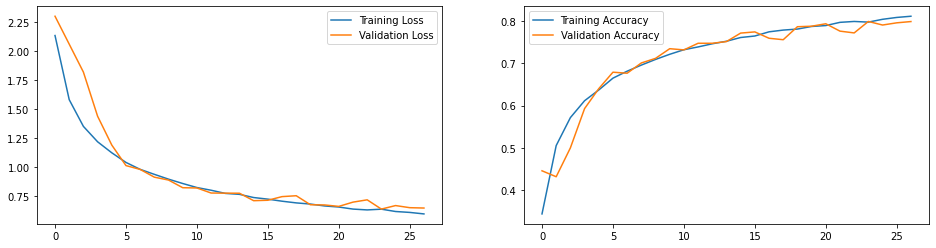

In [79]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [80]:
pred1= model.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)

In [81]:
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.86      0.74      0.79      1000
           1       0.95      0.87      0.90      1000
           2       0.73      0.66      0.69      1000
           3       0.62      0.67      0.64      1000
           4       0.74      0.81      0.78      1000
           5       0.71      0.72      0.72      1000
           6       0.82      0.88      0.85      1000
           7       0.88      0.80      0.84      1000
           8       0.78      0.92      0.85      1000
           9       0.88      0.85      0.86      1000

    accuracy                           0.79     10000
   macro avg       0.80      0.79      0.79     10000
weighted avg       0.80      0.79      0.79     10000

Accuracy Score: 0.7916
Root Mean Square Error: 1.8626325456192372


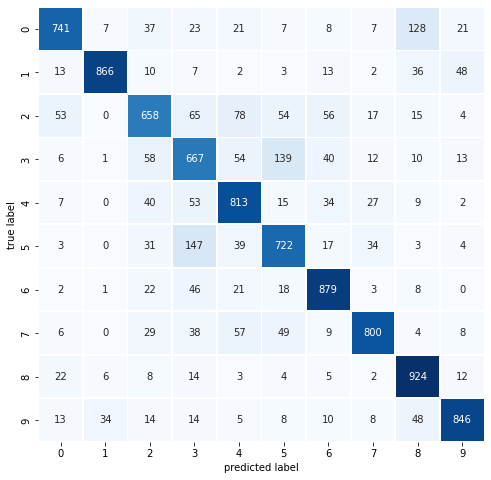

In [82]:
plot_confusion_matrix(y_test,pred1)

In [83]:
model = models.Sequential()
model.add(layers.Conv3D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=(32, 32, 3)))
model.add(layers.MaxPool2D((2, 2),strides=2))
model.add(layers.Dropout(0.3))
model.add(layers.Conv3D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model.add(layers.MaxPool3D(pool_size=(2, 2),strides=2))
model.add(layers.Dropout(0.3))
model.add(layers.Conv3D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model.add(layers.MaxPool3D(pool_size=(2, 2),strides=2))
model.add(layers.Dropout(0.3))
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(units=384, activation = tf.nn.relu, kernel_regularizer = tf.keras.regularizers.L1(0.001)))
model.add(layers.Dense(units=256, activation=tf.nn.softmax))

In [84]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 512)       14336     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 15, 15, 512)      0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 15, 15, 512)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 256)       1179904   
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 6, 6, 256)        

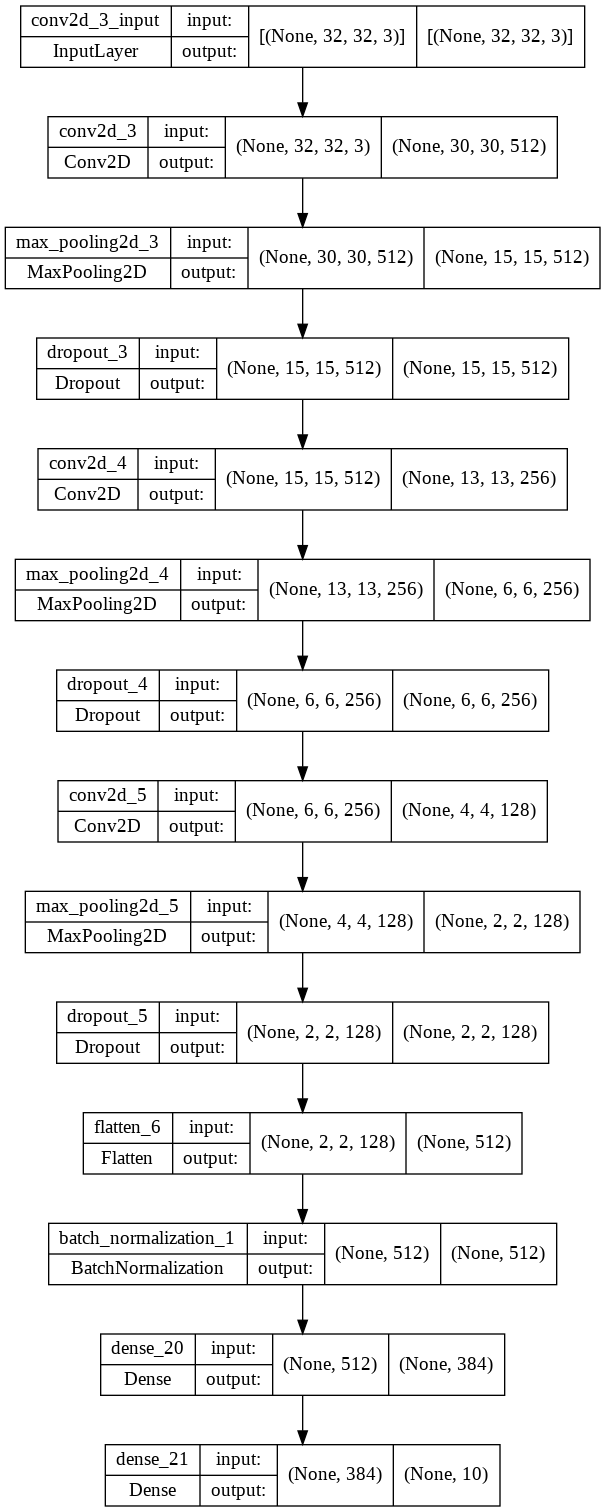

In [85]:
keras.utils.plot_model(model, "CIFAR10.png", show_shapes=True) 

In addition to setting up our model architecture, we also need to define which algorithm should the model use in order to optimize the weights and biases as per the given data. We will use stochastic gradient descent.

We also need to define a loss function. Think of this function as the difference between the predicted outputs and the actual outputs given in the dataset. This loss needs to be minimised in order to have a higher model accuracy. That's what the optimization algorithm essentially does - it minimises the loss during model training. For our multi-class classification problem, categorical cross entropy is commonly used.

Finally, we will use the accuracy during training as a metric to keep track of as the model trains.

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [86]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

<div class="alert alert-block alert-success">
    <b>Module: tf.keras.callbacks</b></div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.EarlyStopping</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping</div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.ModelCheckpoint</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint</div>

In [87]:
history = model.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=512
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    tf.keras.callbacks.ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/models/model_{val_accuracy:.4f}.h5', save_best_only=True,
                                        save_weights_only=False, monitor='val_accuracy')]                                                                                                           
                   )

Epoch 1/200
88/88 [==============================] - 17s 183ms/step - loss: 6.0556 - accuracy: 0.3402 - val_loss: 3.4667 - val_accuracy: 0.4300
Epoch 2/200
88/88 [==============================] - 16s 183ms/step - loss: 2.0718 - accuracy: 0.5061 - val_loss: 2.1306 - val_accuracy: 0.4970
Epoch 3/200
88/88 [==============================] - 16s 180ms/step - loss: 1.5267 - accuracy: 0.5631 - val_loss: 1.8245 - val_accuracy: 0.5286
Epoch 4/200
88/88 [==============================] - 16s 177ms/step - loss: 1.3805 - accuracy: 0.6060 - val_loss: 1.5909 - val_accuracy: 0.5734
Epoch 5/200
88/88 [==============================] - 15s 176ms/step - loss: 1.2892 - accuracy: 0.6385 - val_loss: 1.3503 - val_accuracy: 0.6430
Epoch 6/200
88/88 [==============================] - 16s 177ms/step - loss: 1.2368 - accuracy: 0.6548 - val_loss: 1.2346 - val_accuracy: 0.6726
Epoch 7/200
88/88 [==============================] - 16s 177ms/step - loss: 1.1785 - accuracy: 0.6746 - val_loss: 1.2862 - val_accuracy:


Data on which to evaluate the loss and any model metrics at the end of each epoch<br>
The model will not be trained on this data

In order to ensure that this is not a simple "memorization" by the machine, we should evaluate the performance on the test set. This is easy to do, we simply use the `evaluate` method on our model.

In [88]:
loss, accuracy = model.evaluate(x_test_norm, y_test)
print('test set accuracy: ', accuracy * 100)

313/313 [==============================] - 2s 6ms/step - loss: 0.8882 - accuracy: 0.7600
test set accuracy:  75.99999904632568


In [89]:
preds = model.predict(x_test_norm)
print('shape of preds: ', preds.shape)

shape of preds:  (10000, 10)




We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [90]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [91]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
17,0.873,0.767,0.851,0.774
18,0.858,0.770,0.853,0.775
19,0.852,0.770,0.862,0.771
20,0.825,0.779,0.880,0.764
21,0.813,0.782,0.880,0.757


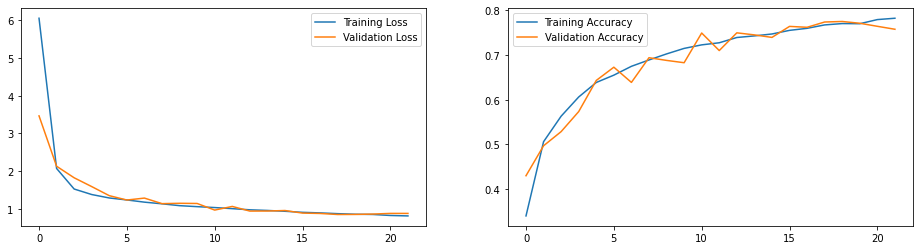

In [93]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()


Using both `sklearn.metrics`. Then we visualize the confusion matrix and see what that tells us.

In [95]:
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.82      0.79      0.81      1000
           1       0.90      0.89      0.90      1000
           2       0.82      0.48      0.61      1000
           3       0.60      0.53      0.56      1000
           4       0.71      0.76      0.73      1000
           5       0.51      0.87      0.65      1000
           6       0.84      0.79      0.82      1000
           7       0.83      0.78      0.81      1000
           8       0.87      0.89      0.88      1000
           9       0.89      0.81      0.85      1000

    accuracy                           0.76     10000
   macro avg       0.78      0.76      0.76     10000
weighted avg       0.78      0.76      0.76     10000

Accuracy Score: 0.76
Root Mean Square Error: 1.8644033898274268


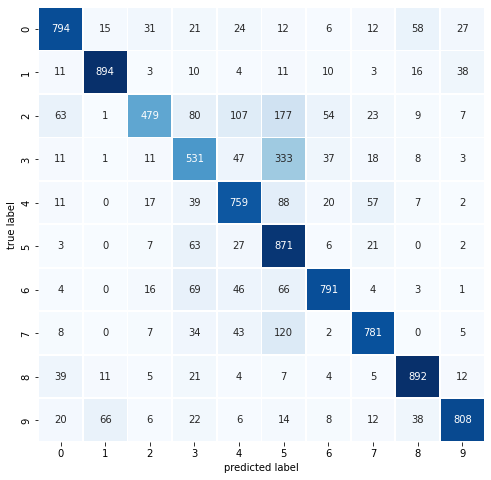

In [96]:
plot_confusion_matrix(y_test,pred1)

<div class="alert alert-block alert-info">
<b>tf.keras.models.load_model</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/models/load_model</div>

In [97]:
model = tf.keras.models.load_model('/content/gdrive/My Drive/Colab Notebooks/models/model_0.7666.h5')

In [98]:
preds = model.predict(x_test_norm)

In [101]:
df = pd.DataFrame(preds[0:20], columns = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
0,0.18%,0.06%,0.11%,96.03%,0.04%,1.61%,0.74%,0.03%,1.19%,0.02%
1,0.55%,17.52%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,81.85%,0.08%
2,3.35%,12.63%,0.13%,0.38%,0.01%,0.02%,0.03%,0.01%,82.46%,0.97%
3,95.76%,0.89%,1.33%,0.10%,0.03%,0.00%,0.01%,0.00%,1.88%,0.01%
4,0.00%,0.01%,1.24%,0.53%,4.58%,0.04%,93.57%,0.01%,0.02%,0.00%
5,0.00%,0.04%,0.08%,11.14%,0.74%,5.88%,81.87%,0.16%,0.02%,0.06%
6,0.02%,83.54%,0.00%,0.02%,0.00%,0.01%,0.00%,0.00%,0.00%,16.40%
7,0.47%,0.01%,9.75%,5.06%,13.21%,1.38%,69.84%,0.09%,0.17%,0.02%
8,0.09%,0.00%,0.99%,92.35%,1.23%,3.69%,0.68%,0.95%,0.01%,0.02%
9,0.06%,78.15%,0.04%,0.01%,0.00%,0.00%,0.09%,0.00%,0.01%,21.64%


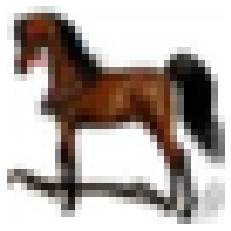

In [102]:
(_,_), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

img = test_images[2004]
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

plt.imshow(img, cmap='viridis')
plt.axis('off')
plt.show()

In [104]:
activations = activation_model.predict(img_tensor)
len(activations)

8

In [105]:
layer_names = []
for layer in model.layers:
    layer_names.append(layer.name)
    
layer_names

['conv2d_2',
 'max_pooling2d_2',
 'dropout_2',
 'conv2d_3',
 'max_pooling2d_3',
 'dropout_3',
 'conv2d_4',
 'max_pooling2d_4',
 'dropout_4',
 'flatten_4',
 'batch_normalization_1',
 'dense_11']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


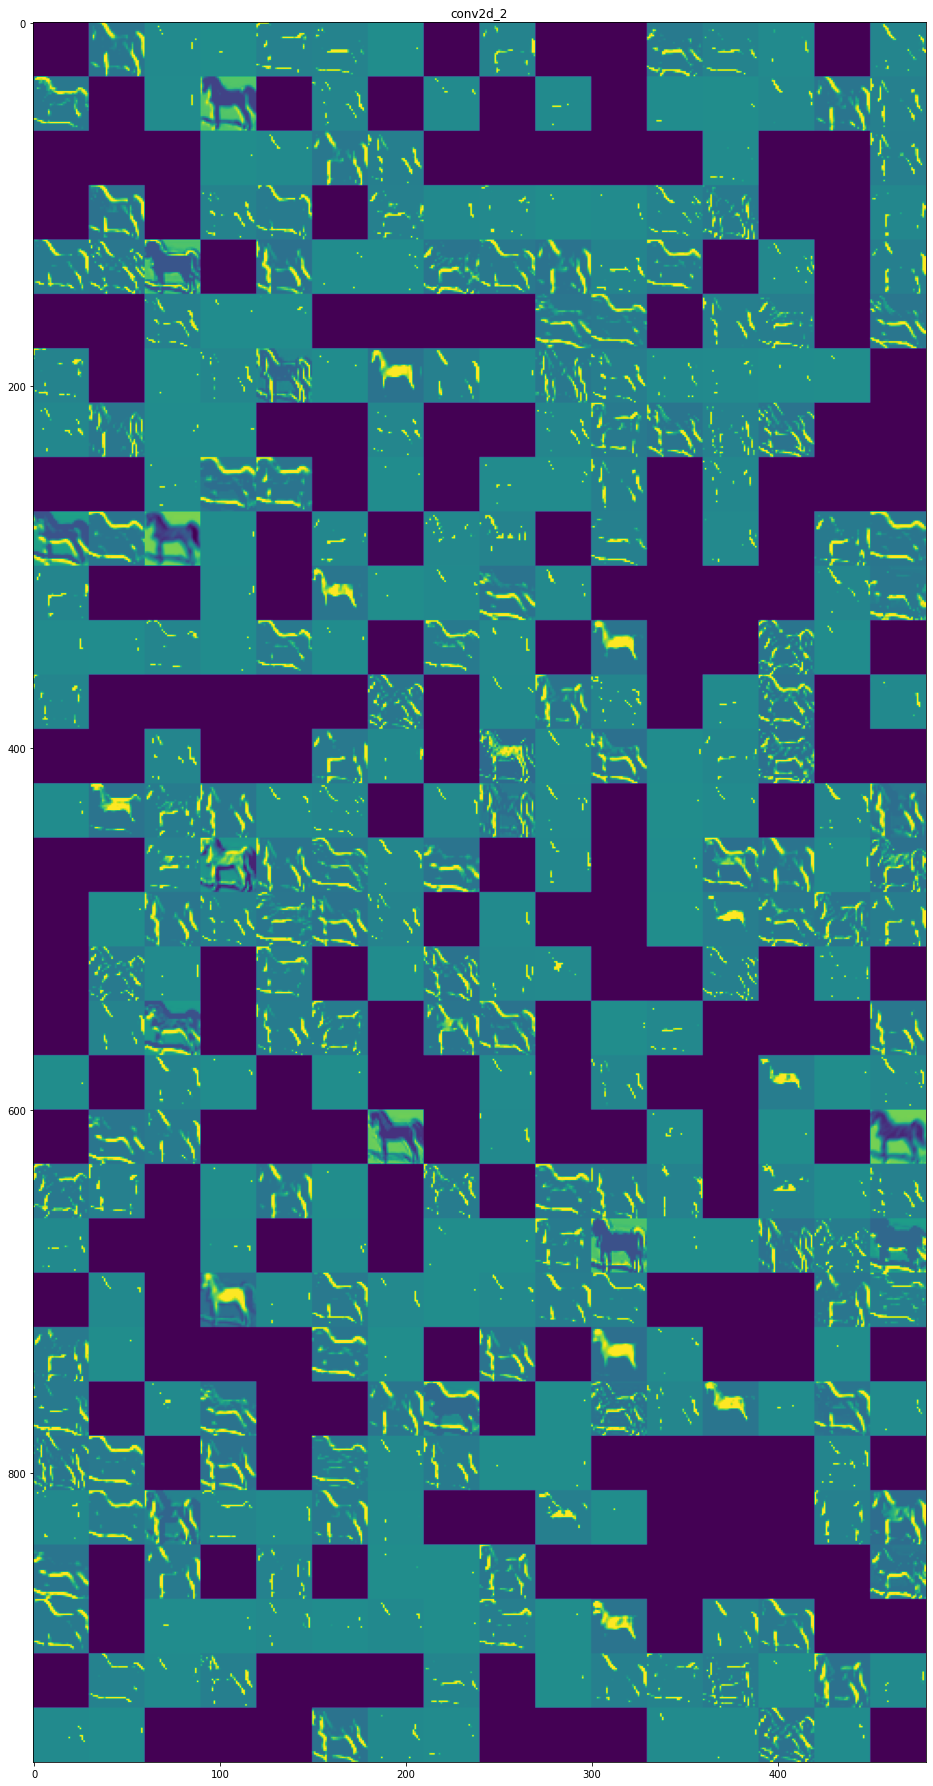

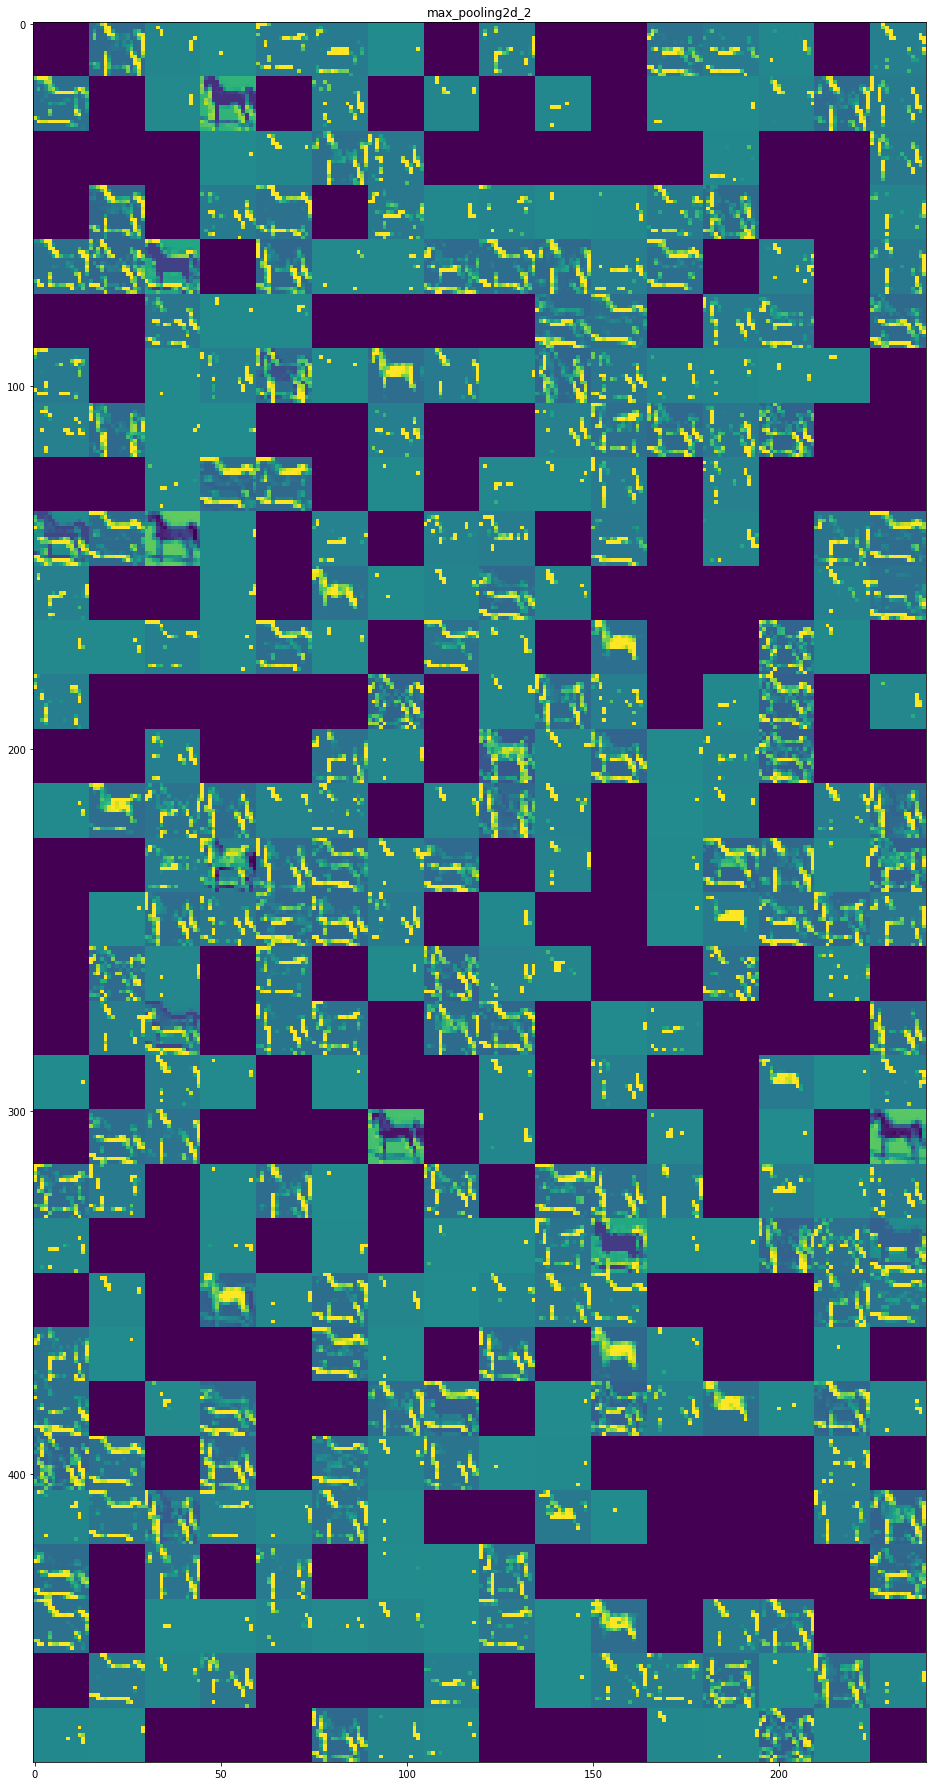

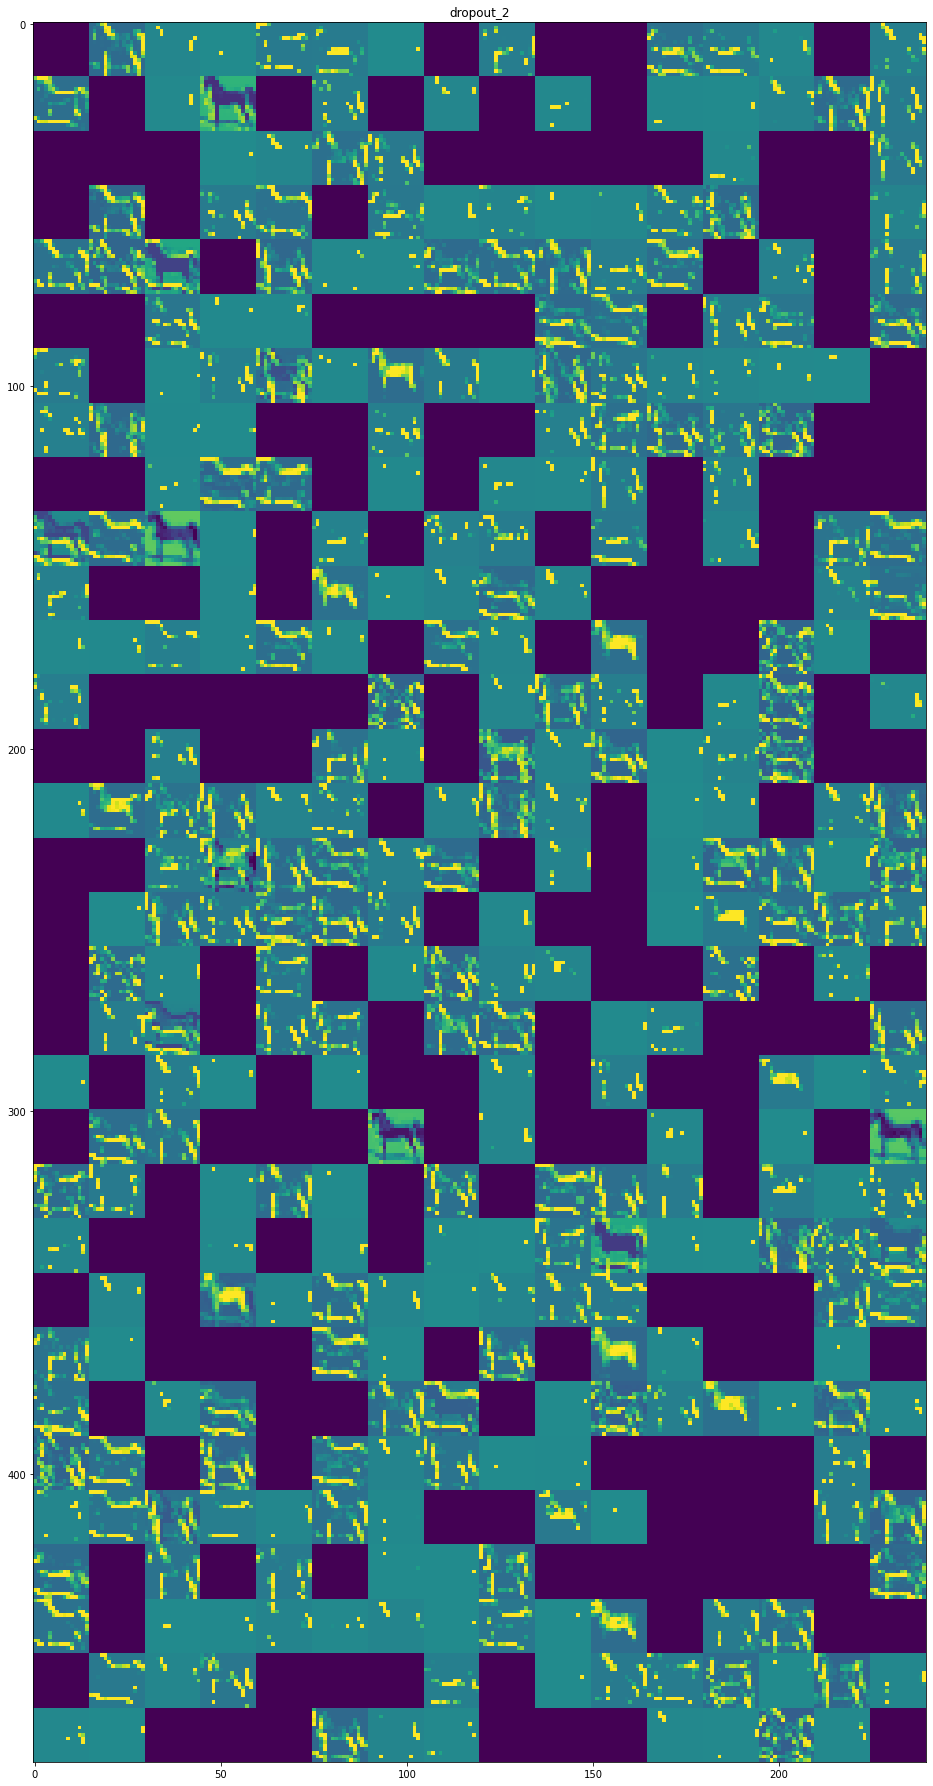

In [106]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:3]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show();